In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
sns.set_style("whitegrid")

# Global Constants
SEQUENCE_LENGTH = 30
RUL_CAP = 125
FAILURE_THRESHOLD_N = 30 
BASE_DIR = r'C:\\Users\\LENOVO\\Downloads\\turbofan project\\Datas' 

# All utility functions combined
def get_selected_features(dataset_name):
    sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
    setting_names = ['setting_1', 'setting_2', 'setting_3']
    irrelevant_sensors = ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
    features_to_keep = [f for f in sensor_names if f not in irrelevant_sensors]
    if dataset_name in ['FD002', 'FD004']:
        features_to_keep.extend(setting_names)
    return features_to_keep

def calculate_RUL(df):
    max_cycles_df = df.groupby('unit_number')['time_cycles'].max().reset_index()
    df = df.merge(max_cycles_df, on='unit_number', how='left', suffixes=['', '_max'])
    df['RUL'] = df['time_cycles_max'] - df['time_cycles']
    df['RUL_capped'] = np.where(df['RUL'] > RUL_CAP, RUL_CAP, df['RUL'])
    df.drop('time_cycles_max', axis=1, inplace=True)
    return df

def create_statistical_features(df, features, window_size=10):
    X, y = [], []
    for engine_id in df['unit_number'].unique():
        engine_data = df[df['unit_number'] == engine_id].reset_index(drop=True)
        for i in range(window_size, len(engine_data)):
            window = engine_data.iloc[i-window_size:i][features].values
            statistical_features = np.concatenate([
                np.mean(window, axis=0), np.std(window, axis=0),
                np.min(window, axis=0), np.max(window, axis=0), window[-1]
            ])
            X.append(statistical_features)
            y.append(engine_data['RUL_capped'].iloc[i])
    return np.array(X), np.array(y)

def create_sequences(df, sequence_length, features, label_column=None):
    X, y = [], []
    for engine_id in df['unit_number'].unique():
        engine_data = df[df['unit_number'] == engine_id][features].values
        if label_column:
            RUL_labels = df[df['unit_number'] == engine_id][label_column].values
        for i in range(len(engine_data) - sequence_length + 1):
            sequence = engine_data[i:i + sequence_length]
            X.append(sequence)
            if label_column:
                y.append(RUL_labels[i + sequence_length - 1])
    return np.array(X), np.array(y) if label_column else np.array(X)

def build_lstm_model(seq_len, n_features):
    input_layer = Input(shape=(seq_len, n_features))
    lstm = LSTM(100, return_sequences=True)(input_layer)
    dropout1 = Dropout(0.2)(lstm)
    lstm2 = LSTM(50, return_sequences=False)(dropout1)
    dropout2 = Dropout(0.2)(lstm2)
    dense1 = Dense(50, activation='relu', name='dense_features')(dropout2)
    output = Dense(1, activation='linear')(dense1)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def cmapss_score(y_true, y_pred):
    d = y_pred - y_true
    score = np.where(d < 0, np.exp(-d / 13) - 1, np.exp(d / 10) - 1)
    return np.sum(score)

def plot_rul_results(y_true, y_pred, dataset_name):
    engine_indices = range(len(y_true))
    plt.figure(figsize=(15, 6))
    plt.plot(engine_indices, y_true, 'o-', label='Actual RUL', color='blue', linewidth=2)
    plt.plot(engine_indices, y_pred, 's--', label='Predicted RUL', color='red', linewidth=2)
    plt.axhline(y=125, color='gray', linestyle=':', label='RUL Cap (125 Cycles)')
    plt.title(f'RUL Prediction Results - {dataset_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Test Engine Index')
    plt.ylabel('Remaining Useful Life (Cycles)')
    plt.legend()
    plt.grid(True, alpha=0.7)
    plt.tight_layout()
    plt.show()

print("Setup complete - All functions loaded!")


Setup complete - All functions loaded!


In [2]:
def run_ensemble_analysis(dataset_name):
    print(f"\n ANALYZING {dataset_name} - RF + XGBoost + LSTM Ensemble")
    print("=" * 60)
    
    # Load data
    index_names = ['unit_number', 'time_cycles']
    col_names = index_names + ['setting_1', 'setting_2', 'setting_3'] + ['s_{}'.format(i) for i in range(1, 22)]
    
    try:
        train_file = os.path.join(BASE_DIR, f'train_{dataset_name}.txt')
        test_file = os.path.join(BASE_DIR, f'test_{dataset_name}.txt')
        rul_file = os.path.join(BASE_DIR, f'RUL_{dataset_name}.txt')
        
        train_df = pd.read_csv(train_file, sep='\s+', header=None, names=col_names)
        test_df = pd.read_csv(test_file, sep='\s+', header=None, names=col_names)
        RUL_truth_df = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL_truth'])
        
        print(f" Loaded: {len(train_df['unit_number'].unique())} train engines, {len(test_df['unit_number'].unique())} test engines")
    except:
        print(f" Error loading {dataset_name}")
        return None
    
    # Preprocess
    train_df = calculate_RUL(train_df.copy())
    selected_features = get_selected_features(dataset_name)
    df_train = train_df[['unit_number', 'time_cycles'] + selected_features + ['RUL_capped']]
    df_test = test_df[['unit_number', 'time_cycles'] + selected_features]
    
    # Normalize
    scaler = MinMaxScaler()
    scaler.fit(df_train[selected_features])
    df_train.loc[:, selected_features] = scaler.transform(df_train[selected_features])
    df_test.loc[:, selected_features] = scaler.transform(df_test[selected_features])
    
    print(f"Preprocessed {len(selected_features)} features")
    
    # Create features for RF & XGBoost
    X_train_stat, y_train_stat = create_statistical_features(df_train, selected_features)
    X_test_stat = []
    for engine_id in df_test['unit_number'].unique():
        engine_data = df_test[df_test['unit_number'] == engine_id].tail(10)
        if len(engine_data) >= 10:
            window = engine_data[selected_features].values
            X_test_stat.append(np.concatenate([
                np.mean(window, axis=0), np.std(window, axis=0),
                np.min(window, axis=0), np.max(window, axis=0), window[-1]
            ]))
    X_test_stat = np.array(X_test_stat)
    
    # Create sequences for LSTM
    X_train_seq, y_train_seq = create_sequences(df_train, SEQUENCE_LENGTH, selected_features, 'RUL_capped')
    X_test_seq = create_sequences(df_test, SEQUENCE_LENGTH, selected_features)
    
    if isinstance(X_train_seq, tuple): X_train_seq = X_train_seq[0]
    if isinstance(X_test_seq, tuple): X_test_seq = X_test_seq[0]
    if X_train_seq.ndim == 4: X_train_seq = X_train_seq.reshape(-1, X_train_seq.shape[-2], X_train_seq.shape[-1])
    if X_test_seq.ndim == 4: X_test_seq = X_test_seq.reshape(-1, X_test_seq.shape[-2], X_test_seq.shape[-1])
    
    print(f" Features created - Statistical: {X_train_stat.shape}, Sequential: {X_train_seq.shape}")
    
    # Train models
    print(" Training Random Forest...")
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_stat, y_train_stat)
    rf_pred = rf_model.predict(X_test_stat)
    
    print(" Training XGBoost...")
    xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0)
    xgb_model.fit(X_train_stat, y_train_stat)
    xgb_pred = xgb_model.predict(X_test_stat)
    
    print(" Training LSTM...")
    keras.backend.clear_session()
    lstm_model = build_lstm_model(SEQUENCE_LENGTH, X_train_seq.shape[2])
    early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=0, restore_best_weights=True)
    lstm_model.fit(X_train_seq, y_train_seq, epochs=80, batch_size=256, validation_split=0.2, callbacks=[early_stop], verbose=0)
    
    # Get LSTM predictions (last sequence per engine)
    test_max_cycles = df_test.groupby('unit_number')['time_cycles'].max()
    start_idx, last_seq_indices = 0, []
    for max_cycle in test_max_cycles.values:
        num_seq = max_cycle - SEQUENCE_LENGTH + 1
        last_seq_indices.append(start_idx + num_seq - 1)
        start_idx += num_seq
    
    lstm_all_pred = lstm_model.predict(X_test_seq, verbose=0).flatten()
    lstm_pred = lstm_all_pred[last_seq_indices]
    
    # Ensemble prediction (simple average)
    min_len = min(len(rf_pred), len(xgb_pred), len(lstm_pred), len(RUL_truth_df))
    rf_final = rf_pred[:min_len]
    xgb_final = xgb_pred[:min_len]  
    lstm_final = lstm_pred[:min_len]
    y_true = RUL_truth_df['RUL_truth'].values[:min_len]
    
    ensemble_pred = (rf_final + xgb_final + lstm_final) / 3.0
    
    # Calculate metrics
    rf_rmse = math.sqrt(mean_squared_error(y_true, rf_final))
    xgb_rmse = math.sqrt(mean_squared_error(y_true, xgb_final))
    lstm_rmse = math.sqrt(mean_squared_error(y_true, lstm_final))
    ensemble_rmse = math.sqrt(mean_squared_error(y_true, ensemble_pred))
    ensemble_score = cmapss_score(y_true, ensemble_pred)
    
    print(f"\n RESULTS for {dataset_name}:")
    print(f"    Random Forest: {rf_rmse:.3f}")
    print(f"    XGBoost:       {xgb_rmse:.3f}")
    print(f"    LSTM:          {lstm_rmse:.3f}")
    print(f"    ENSEMBLE:      {ensemble_rmse:.3f} (C-MAPSS: {ensemble_score:.0f})")
    
    # Plot results
    plot_rul_results(y_true, ensemble_pred, dataset_name)
    
    return {
        'Dataset': dataset_name,
        'RF_RMSE': rf_rmse,
        'XGB_RMSE': xgb_rmse,
        'LSTM_RMSE': lstm_rmse,
        'Ensemble_RMSE': ensemble_rmse,
        'C_MAPSS_Score': ensemble_score
    }

print("Analysis function ready!")


Analysis function ready!


 STARTING RF + XGBOOST + LSTM ENSEMBLE ANALYSIS

 ANALYZING FD001 - RF + XGBoost + LSTM Ensemble
 Loaded: 100 train engines, 100 test engines
Preprocessed 14 features
 Features created - Statistical: (19631, 70), Sequential: (17731, 30, 14)
 Training Random Forest...
 Training XGBoost...
 Training LSTM...


 RESULTS for FD001:
    Random Forest: 20.419
    XGBoost:       20.274
    LSTM:          14.636
    ENSEMBLE:      17.425 (C-MAPSS: 653)


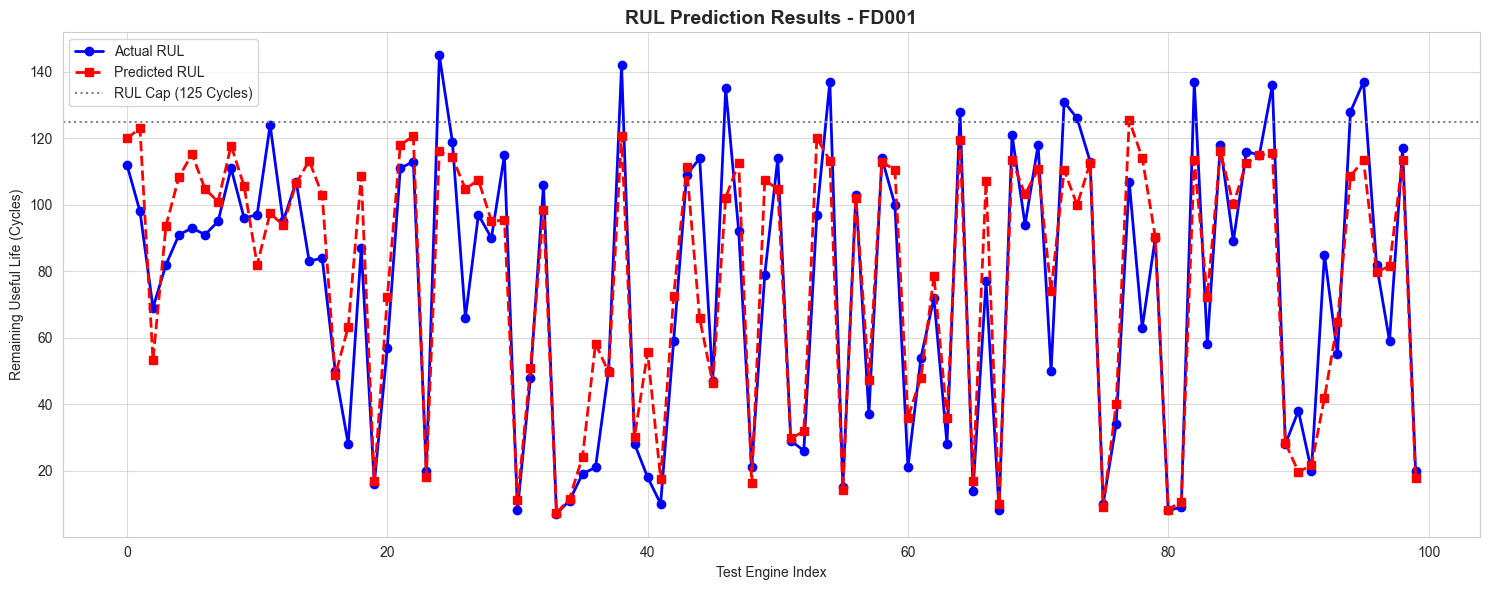


 ANALYZING FD002 - RF + XGBoost + LSTM Ensemble
 Loaded: 260 train engines, 259 test engines
Preprocessed 17 features
 Features created - Statistical: (51159, 85), Sequential: (46219, 30, 17)
 Training Random Forest...
 Training XGBoost...
 Training LSTM...

 RESULTS for FD002:
    Random Forest: 31.303
    XGBoost:       30.994
    LSTM:          38.261
    ENSEMBLE:      31.484 (C-MAPSS: 18883)


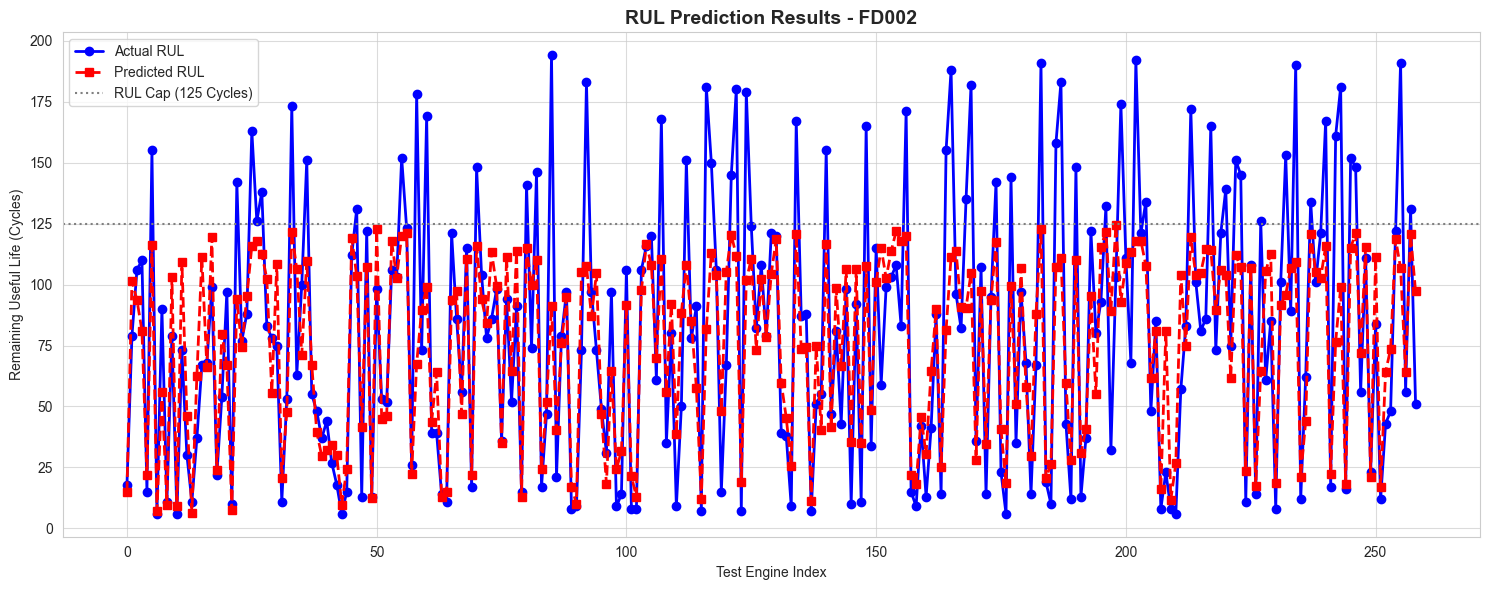


 ANALYZING FD003 - RF + XGBoost + LSTM Ensemble
 Loaded: 100 train engines, 100 test engines
Preprocessed 14 features
 Features created - Statistical: (23720, 70), Sequential: (21820, 30, 14)
 Training Random Forest...
 Training XGBoost...
 Training LSTM...

 RESULTS for FD003:
    Random Forest: 21.459
    XGBoost:       20.540
    LSTM:          15.361
    ENSEMBLE:      18.133 (C-MAPSS: 802)


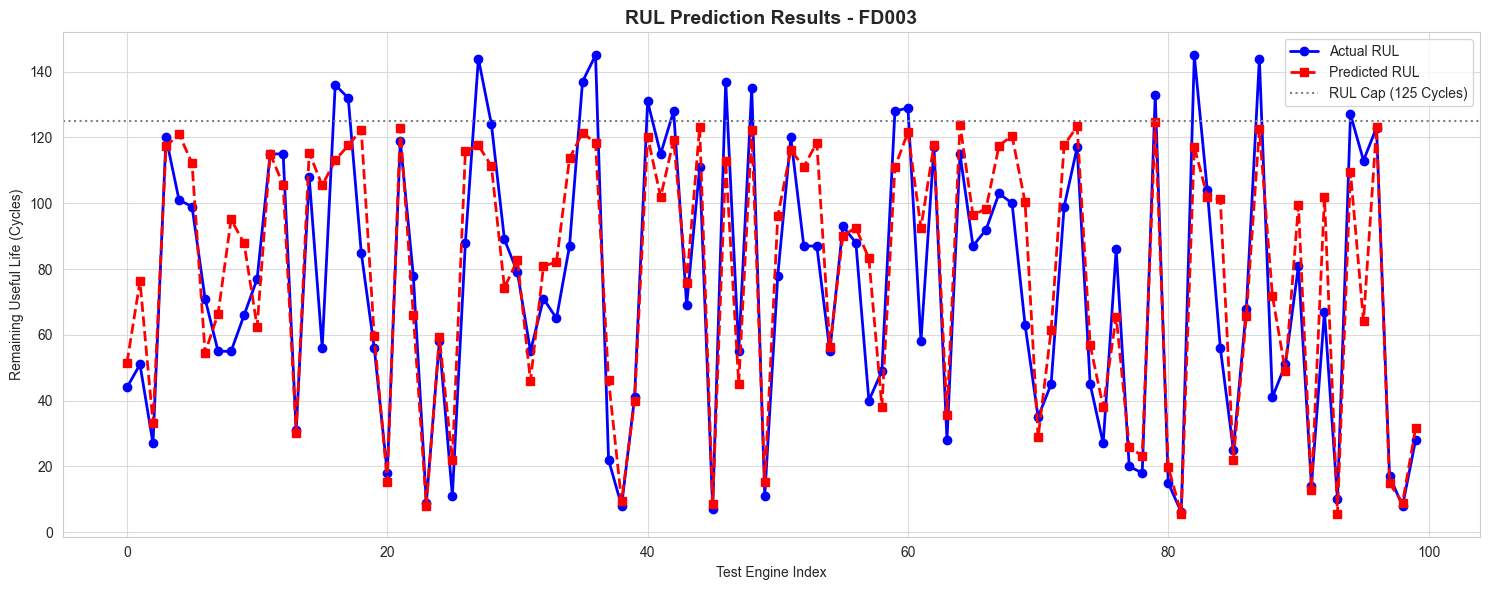


 ANALYZING FD004 - RF + XGBoost + LSTM Ensemble
 Loaded: 249 train engines, 248 test engines
Preprocessed 17 features
 Features created - Statistical: (58759, 85), Sequential: (54028, 30, 17)
 Training Random Forest...
 Training XGBoost...
 Training LSTM...

 RESULTS for FD004:
    Random Forest: 31.394
    XGBoost:       30.866
    LSTM:          45.914
    ENSEMBLE:      33.131 (C-MAPSS: 10111)


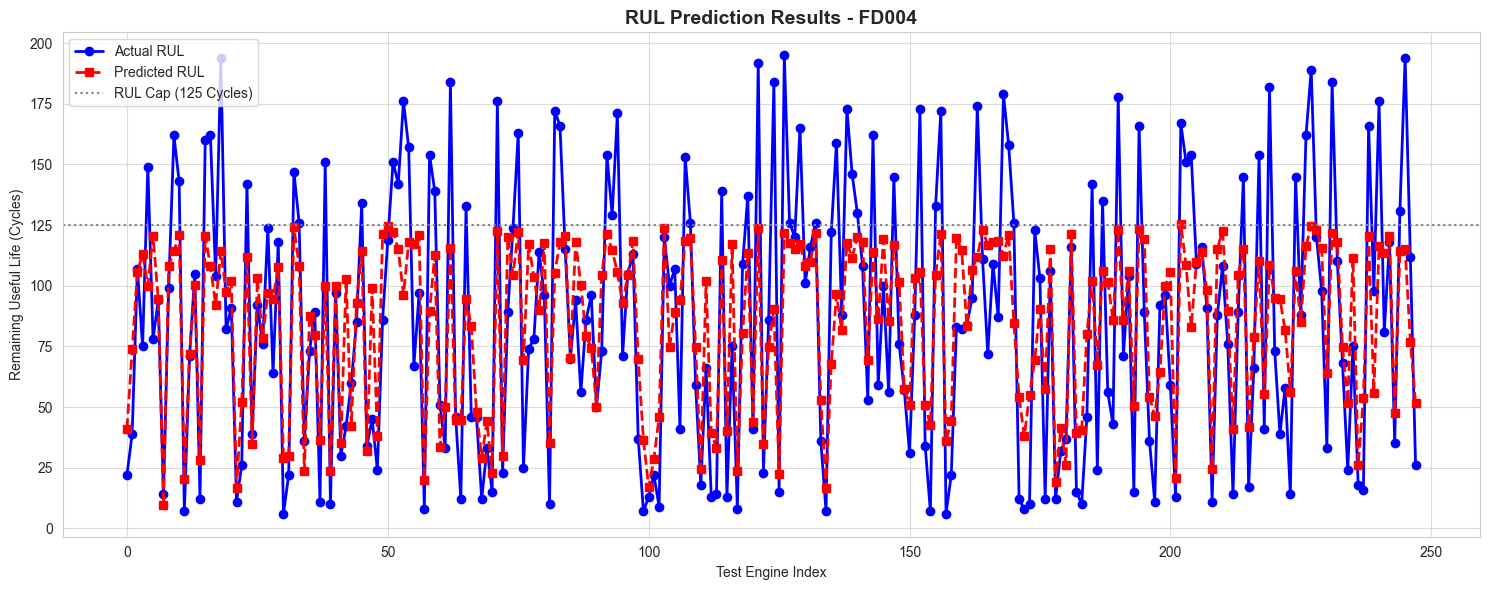


 All analyses completed!


In [3]:
# Run analysis for all datasets
datasets = ['FD001', 'FD002', 'FD003', 'FD004']
results = []

print(" STARTING RF + XGBOOST + LSTM ENSEMBLE ANALYSIS")
print("="*80)

for dataset in datasets:
    result = run_ensemble_analysis(dataset)
    if result:
        results.append(result)

print("\n All analyses completed!")



 RF + XGBOOST + LSTM ENSEMBLE - FINAL RESULTS
Dataset RF_RMSE XGB_RMSE LSTM_RMSE Ensemble_RMSE C_MAPSS_Score
  FD001  20.419   20.274    14.636        17.425           653
  FD002  31.303   30.994    38.261        31.484         18883
  FD003  21.459   20.540    15.361        18.133           802
  FD004  31.394   30.866    45.914        33.131         10111

 Generating Model Comparison Chart...


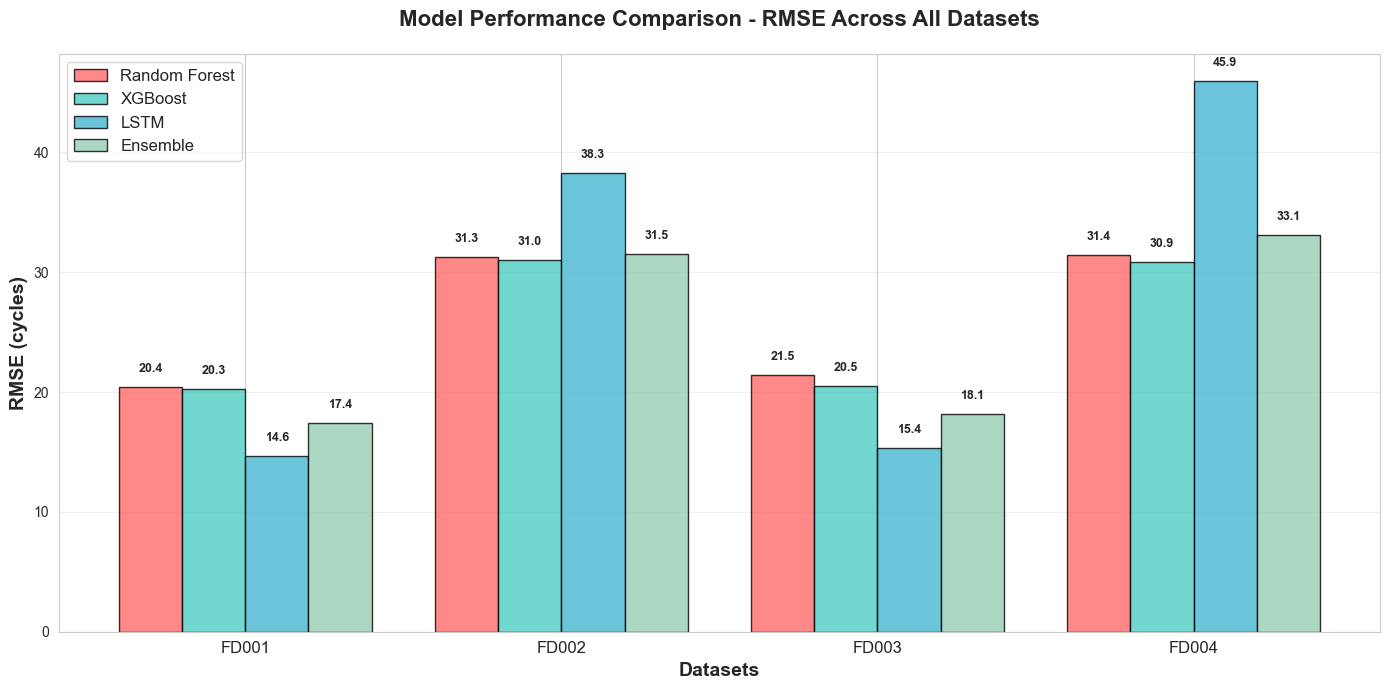


 AVERAGE PERFORMANCE:
----------------------------------------
 Random Forest:  26.144
 XGBoost:        25.669
 LSTM:           28.543
 ENSEMBLE:       25.043
 Avg C-MAPSS:    7612

 BEST MODEL: Ensemble (Avg RMSE: 25.043)
    Ensemble improves over XGBoost by 2.4%

 DATASET DIFFICULTY (by Ensemble RMSE):
   1. FD001: 17.425 (Easy)
   2. FD003: 18.133 (Easy)
   3. FD002: 31.484 (Hard)
   4. FD004: 33.131 (Hard)

 ANALYSIS COMPLETE!


In [4]:
# Display comprehensive results
if results:
    results_df = pd.DataFrame(results)
    
    print(f"\n{'='*80}")
    print(" RF + XGBOOST + LSTM ENSEMBLE - FINAL RESULTS")
    print(f"{'='*80}")
    
    # Format for display
    display_df = results_df.copy()
    for col in ['RF_RMSE', 'XGB_RMSE', 'LSTM_RMSE', 'Ensemble_RMSE']:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.3f}")
    display_df['C_MAPSS_Score'] = display_df['C_MAPSS_Score'].apply(lambda x: f"{x:.0f}")
    
    print(display_df.to_string(index=False))
    
    #  CREATE SIMPLE BAR CHART FOR MODEL COMPARISON
    
    print(f"\n Generating Model Comparison Chart...")
    
    # Prepare data
    datasets = results_df['Dataset'].tolist()
    rf_rmse = results_df['RF_RMSE'].tolist()
    xgb_rmse = results_df['XGB_RMSE'].tolist()
    lstm_rmse = results_df['LSTM_RMSE'].tolist()
    ensemble_rmse = results_df['Ensemble_RMSE'].tolist()
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(14, 7))
    
    x_pos = np.arange(len(datasets))
    width = 0.2
    
    # Plot bars for each model
    bars1 = ax.bar(x_pos - 1.5*width, rf_rmse, width, label='Random Forest', color='#FF6B6B', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x_pos - 0.5*width, xgb_rmse, width, label='XGBoost', color='#4ECDC4', alpha=0.8, edgecolor='black')
    bars3 = ax.bar(x_pos + 0.5*width, lstm_rmse, width, label='LSTM', color='#45B7D1', alpha=0.8, edgecolor='black')
    bars4 = ax.bar(x_pos + 1.5*width, ensemble_rmse, width, label='Ensemble', color='#96CEB4', alpha=0.8, edgecolor='black')
    
    # Customize chart
    ax.set_xlabel('Datasets', fontsize=14, fontweight='bold')
    ax.set_ylabel('RMSE (cycles)', fontsize=14, fontweight='bold')
    ax.set_title('Model Performance Comparison - RMSE Across All Datasets', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(datasets, fontsize=12)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    #  NUMERICAL SUMMARY
    
    print(f"\n AVERAGE PERFORMANCE:")
    print("-" * 40)
    avg_rf = results_df['RF_RMSE'].mean()
    avg_xgb = results_df['XGB_RMSE'].mean()
    avg_lstm = results_df['LSTM_RMSE'].mean()
    avg_ensemble = results_df['Ensemble_RMSE'].mean()
    avg_cmapss = results_df['C_MAPSS_Score'].mean()
    
    print(f" Random Forest:  {avg_rf:.3f}")
    print(f" XGBoost:        {avg_xgb:.3f}")
    print(f" LSTM:           {avg_lstm:.3f}")
    print(f" ENSEMBLE:       {avg_ensemble:.3f}")
    print(f" Avg C-MAPSS:    {avg_cmapss:.0f}")
    
    # Find best model
    model_performance = {
        'Random Forest': avg_rf,
        'XGBoost': avg_xgb,
        'LSTM': avg_lstm,
        'Ensemble': avg_ensemble
    }
    
    best_model = min(model_performance.items(), key=lambda x: x[1])
    
    print(f"\n BEST MODEL: {best_model[0]} (Avg RMSE: {best_model[1]:.3f})")
    
    if best_model[0] == 'Ensemble':
        second_best = sorted(model_performance.items(), key=lambda x: x[1])[1]
        improvement = (second_best[1] - avg_ensemble) / second_best[1] * 100
        print(f"    Ensemble improves over {second_best[0]} by {improvement:.1f}%")
    
    # Dataset difficulty ranking
    print(f"\n DATASET DIFFICULTY (by Ensemble RMSE):")
    dataset_difficulty = results_df.sort_values('Ensemble_RMSE')[['Dataset', 'Ensemble_RMSE']]
    for i, (_, row) in enumerate(dataset_difficulty.iterrows(), 1):
        difficulty = "Easy" if i <= 2 else "Hard"
        print(f"   {i}. {row['Dataset']}: {row['Ensemble_RMSE']:.3f} ({difficulty})")
    
    print(f"\n ANALYSIS COMPLETE!")
    print("="*80)
    
else:
    print(" No results to display")
